In [377]:
import os
import copy
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import pandas as pd

In [378]:
with open('train.csv', 'r') as file:
    content = file.read()


print("Number of characters in dataset:", len(content))
print(content[:500])

Number of characters in dataset: 60302
PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.25,,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.925,,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1,C123,S
5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.05,,S
6,0,3,"Moran, Mr. James",male,,0,0,330877,8.


In [379]:
content_lines = content.splitlines()
rows = len(content_lines)
for i in range(rows):
    content_lines[i] = content_lines[i].split(",")
    
rows = rows - 1
cols = len(content_lines[0])
label_names = content_lines[0]

dataset_noisy = []
for i in range(1, rows+1):
    lista = []
    for k in range(cols):
        if content_lines[i][k] == '':
            lista.append(np.nan)
        else:
            lista.append(content_lines[i][k])
        
    dataset_noisy.append(lista)
dataset_noisy = np.array(dataset_noisy)
print(dataset_noisy)
print(dataset_noisy.shape)

[['1' '0' '3' ... 'A/5 21171' '7.25' 'nan']
 ['2' '1' '1' ... 'PC 17599' '71.2833' 'C85']
 ['3' '1' '3' ... 'STON/O2. 3101282' '7.925' 'nan']
 ...
 ['889' '0' '3' ... 'W./C. 6607' '23.45' 'nan']
 ['890' '1' '1' ... '111369' '30' 'C148']
 ['891' '0' '3' ... '370376' '7.75' 'nan']]
(891, 12)


In [380]:
print(dataset_noisy[0])
dataset_noisy[:, 5] = np.where(dataset_noisy[:, 5] == 'male', 1, 0)
print(dataset_noisy[0])
if dataset_noisy.shape[1] == 12:
    dataset_noisy = np.delete(dataset_noisy, 9, axis=1)
    dataset_noisy = np.delete(dataset_noisy, 10, axis=1)
    dataset_noisy = np.delete(dataset_noisy, 3, axis=1)
    dataset_noisy = np.delete(dataset_noisy, 3, axis=1)


cols = len(dataset_noisy[1])
print(dataset_noisy[0])
print(cols)

['1' '0' '3' '"Braund' ' Mr. Owen Harris"' 'male' '22' '1' '0' 'A/5 21171'
 '7.25' 'nan']
['1' '0' '3' '"Braund' ' Mr. Owen Harris"' '1' '22' '1' '0' 'A/5 21171'
 '7.25' 'nan']
['1' '0' '3' '1' '22' '1' '0' '7.25']
8


In [381]:
dataset_noisy = np.array(dataset_noisy, dtype=np.float32)

In [382]:
zerosarray = np.ones((rows, 1), dtype=np.float32)
dataset = np.hstack((dataset_noisy, zerosarray))
where_nan_values = np.where(np.isnan(dataset_noisy))
dataset[where_nan_values[0], 4] = 0
dataset[where_nan_values[0], 8] = 0

In [383]:
thirdquarter = int((rows/2) + (rows/4)) + 1
dataset_split_train = dataset[:thirdquarter, :]
dataset_split_val = dataset[thirdquarter:, :]

print(len(dataset_split_train))
print(len(dataset_split_val))

669
222


In [384]:
class PredictionDataset(Dataset):
    def __init__(self, dataset):
        self.xs = torch.tensor(np.delete(dataset, 1, axis=1), dtype=torch.float32)
        self.ys = torch.tensor(dataset[:, 1], dtype=torch.float32).view(-1, 1)

    def __len__(self):
        return self.xs.shape[0]

    def __getitem__(self, idx):
        return self.xs[idx, :], self.ys[idx]

dataloader_reg_train = PredictionDataset(dataset_split_train)
dataloader_reg_val = PredictionDataset(dataset_split_val)

dataloader_reg_train = DataLoader(dataloader_reg_train, batch_size=24)
dataloader_reg_val = DataLoader(dataloader_reg_val, batch_size=24)

In [385]:
cols = len(dataset_split_train[0])
class SurviveClassifierModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 4),
            nn.ReLU(),
            nn.Linear(4, 4),
            nn.ReLU(),
            nn.Linear(4, 1),
            nn.Sigmoid()
          )

    def forward(self, x):
        return self.layers(x)
surv_model = SurviveClassifierModel(input_dim=8)

In [386]:
@torch.no_grad()
def acc_fn(y_hat, y_true):
    assert y_hat.shape == y_true.shape
    correct = torch.sum(torch.round(y_hat) == y_true)
    total = y_hat.numel()
    return correct / total


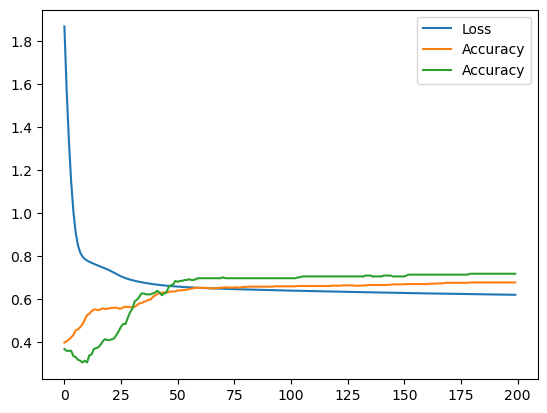

In [387]:
loss_fn = nn.BCELoss()

n_max_epochs = 200
learning_rate = 0.0001
optimizer = torch.optim.Adam(surv_model.parameters(), lr=learning_rate)

train_losses = []
train_accuracy = []
val_losses = []
val_accuracy = []

for i in range(n_max_epochs):
    surv_model.train()
    train_losses_in_epoch = []
    train_accuracy_in_epoch = []

    for xs, ys in dataloader_reg_train:
        optimizer.zero_grad()
        prediction = surv_model(xs)
        loss = loss_fn(prediction, ys)
        accuracy = acc_fn(prediction, ys)
        
        train_losses_in_epoch.append(loss)
        train_accuracy_in_epoch.append(accuracy)

        loss.backward()
        optimizer.step()
        
    train_losses_in_epoch = torch.tensor(train_losses_in_epoch)
    train_accuracy_in_epoch = torch.tensor(train_accuracy_in_epoch)

    avg_loss_in_epoch = train_losses_in_epoch.mean()
    avg_acc_in_epoch = train_accuracy_in_epoch.mean()

    train_losses.append(avg_loss_in_epoch)
    train_accuracy.append(avg_acc_in_epoch)

    surv_model.eval()
    val_losses_in_epoch = []
    val_accuracy_in_epoch = []

    for xs, ys in dataloader_reg_val:
        with torch.no_grad():
            prediction = surv_model(xs)
        loss = loss_fn(ys, prediction)
        acc = acc_fn(prediction, ys)

        val_losses_in_epoch.append(loss)
        val_accuracy_in_epoch.append(acc)

    val_losses_in_epoch = torch.tensor(val_losses_in_epoch)
    val_accuracy_in_epoch = torch.tensor(val_accuracy_in_epoch)

    avg_loss_in_epoch = val_losses_in_epoch.mean()
    avg_acc_in_epoch = val_accuracy_in_epoch.mean()

    val_losses.append(avg_loss_in_epoch)
    val_accuracy.append(avg_acc_in_epoch)
    
    

plt.plot(train_losses, label='Loss')
plt.plot(train_accuracy, label='Accuracy')
plt.plot(val_accuracy, label='Accuracy')

plt.legend()
plt.show()

In [388]:
with open('test.csv', 'r') as file:
    test_content = file.read()
test_content = test_content.splitlines()
for i in range(len(test_content)):
    test_content[i] = test_content[i].split(",")
print(len(test_content))
print(len(test_content[0]))

419
11


In [389]:
array_test = []
for i in range(1, len(test_content)):
    row = test_content[i]
    row[4] = 1 if row[4] == 'male' else 0
    row.pop(8)
    row.pop(10)
    row.pop(2) 
    row.pop(2)
    row.pop(7)
    if row[3] == '':
        row[3] = 0
        row.append(0)
    else:
        row.append(1)
    if row[6] == '':
        row[6] = 0
    array_test.append(row)


In [390]:
array_test = np.array(array_test, dtype=np.float32)
print(array_test)

[[8.92000e+02 3.00000e+00 1.00000e+00 ... 0.00000e+00 7.82920e+00
  1.00000e+00]
 [8.93000e+02 3.00000e+00 0.00000e+00 ... 0.00000e+00 7.00000e+00
  1.00000e+00]
 [8.94000e+02 2.00000e+00 1.00000e+00 ... 0.00000e+00 9.68750e+00
  1.00000e+00]
 ...
 [1.30700e+03 3.00000e+00 1.00000e+00 ... 0.00000e+00 7.25000e+00
  1.00000e+00]
 [1.30800e+03 3.00000e+00 1.00000e+00 ... 0.00000e+00 8.05000e+00
  0.00000e+00]
 [1.30900e+03 3.00000e+00 1.00000e+00 ... 1.00000e+00 2.23583e+01
  0.00000e+00]]


In [391]:
predictions = []
for i in range(len(array_test)):
    data_of_person = torch.tensor(array_test[i])
    prediction = surv_model(data_of_person)
    prediction = (prediction >= 0.5).int()
    passenger_id = int(data_of_person[0])
    survived = int(prediction)
    predictions.append((passenger_id, survived))

In [393]:
print(predictions)
submission_df = pd.DataFrame(predictions, columns=["PassengerId", "Survived"])

# Save to CSV (no index)
submission_df.to_csv("my_submission.csv", index=False)

[(892, 0), (893, 0), (894, 0), (895, 0), (896, 0), (897, 0), (898, 0), (899, 0), (900, 0), (901, 0), (902, 0), (903, 0), (904, 1), (905, 0), (906, 0), (907, 0), (908, 0), (909, 0), (910, 0), (911, 0), (912, 0), (913, 0), (914, 0), (915, 1), (916, 1), (917, 0), (918, 1), (919, 0), (920, 0), (921, 0), (922, 0), (923, 0), (924, 0), (925, 0), (926, 0), (927, 0), (928, 0), (929, 0), (930, 0), (931, 1), (932, 0), (933, 0), (934, 0), (935, 0), (936, 0), (937, 0), (938, 0), (939, 0), (940, 1), (941, 0), (942, 0), (943, 0), (944, 0), (945, 1), (946, 0), (947, 0), (948, 0), (949, 0), (950, 0), (951, 1), (952, 0), (953, 0), (954, 0), (955, 0), (956, 1), (957, 0), (958, 0), (959, 0), (960, 0), (961, 1), (962, 0), (963, 0), (964, 0), (965, 0), (966, 1), (967, 1), (968, 0), (969, 0), (970, 0), (971, 0), (972, 0), (973, 1), (974, 0), (975, 0), (976, 0), (977, 0), (978, 0), (979, 0), (980, 0), (981, 0), (982, 0), (983, 0), (984, 0), (985, 0), (986, 0), (987, 0), (988, 0), (989, 0), (990, 0), (991, 0),